Load dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from datetime import datetime
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

Loading the raw data

In [5]:
df =pd.read_csv('../data/raw_analyst_ratings.csv')

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())
print("\nData types:")
print(df.dtypes)

Dataset shape: (1048575, 6)

First 5 rows:


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A



Data types:
Unnamed: 0     int64
headline      object
url           object
publisher     object
date          object
stock         object
dtype: object


In [6]:
# --- CLEANING ---
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df[df['date'].notna()]  # Drop rows with invalid dates
df['headline'] = df['headline'].fillna("")

In [12]:
# --- Preprocessing ---
df['date'] = pd.to_datetime(df['date'], utc=True).dt.tz_convert(None)
df['headline_length'] = df['headline'].apply(len)

In [13]:
 #--- Descriptive Statistics ---

# Headline length
print("Headline Length Stats:")
print(df['headline_length'].describe())

# Articles per publisher
publisher_counts = df['publisher'].value_counts()
print("\nTop 10 Publishers:")
print(publisher_counts.head(10))

Headline Length Stats:
count    41473.000000
mean        79.649555
std         55.670238
min         15.000000
25%         42.000000
50%         62.000000
75%         91.000000
max        512.000000
Name: headline_length, dtype: float64

Top 10 Publishers:
publisher
Benzinga Newsdesk    11174
Lisa Levin            9412
ETF Professor         3184
Paul Quintaro         3035
Benzinga Newsdesk     2298
Benzinga Insights     1609
Vick Meyer            1582
Charles Gross         1352
Hal Lindon            1068
Benzinga_Newsdesk      902
Name: count, dtype: int64


Based the output the publisher "Benzinga Newsdesk" has been published 11174 articles.

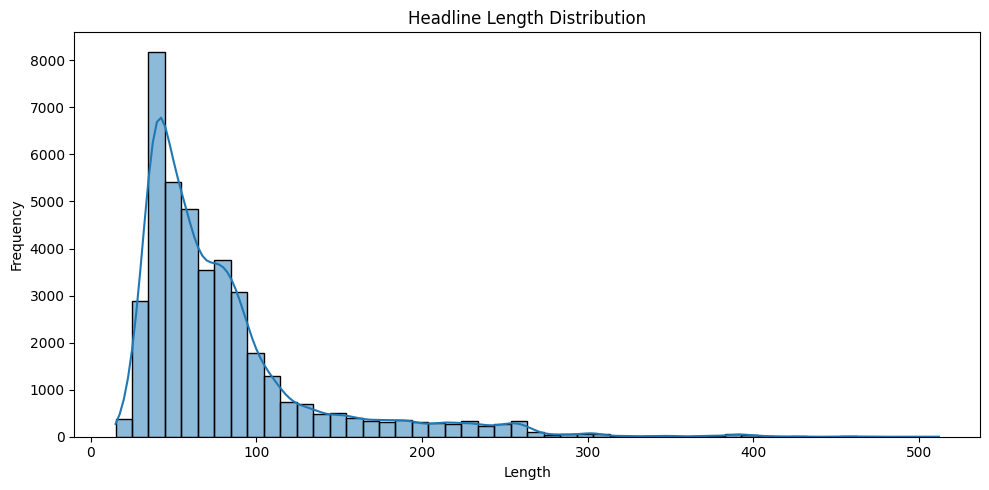

In [14]:
# Plot: Headline Length Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['headline_length'], bins=50, kde=True)
plt.title('Headline Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Display Top Ten publisher

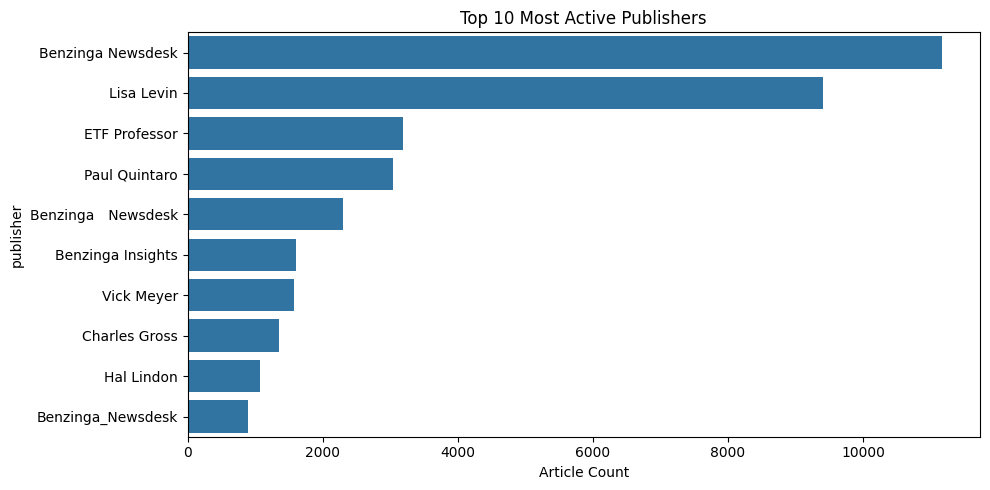

In [15]:
# Plot: Top Publishers
plt.figure(figsize=(10, 5))
top_publishers = publisher_counts.head(10)
sns.barplot(x=top_publishers.values, y=top_publishers.index)
plt.title("Top 10 Most Active Publishers")
plt.xlabel("Article Count")
plt.tight_layout()
plt.show()

 Time Series Analysis

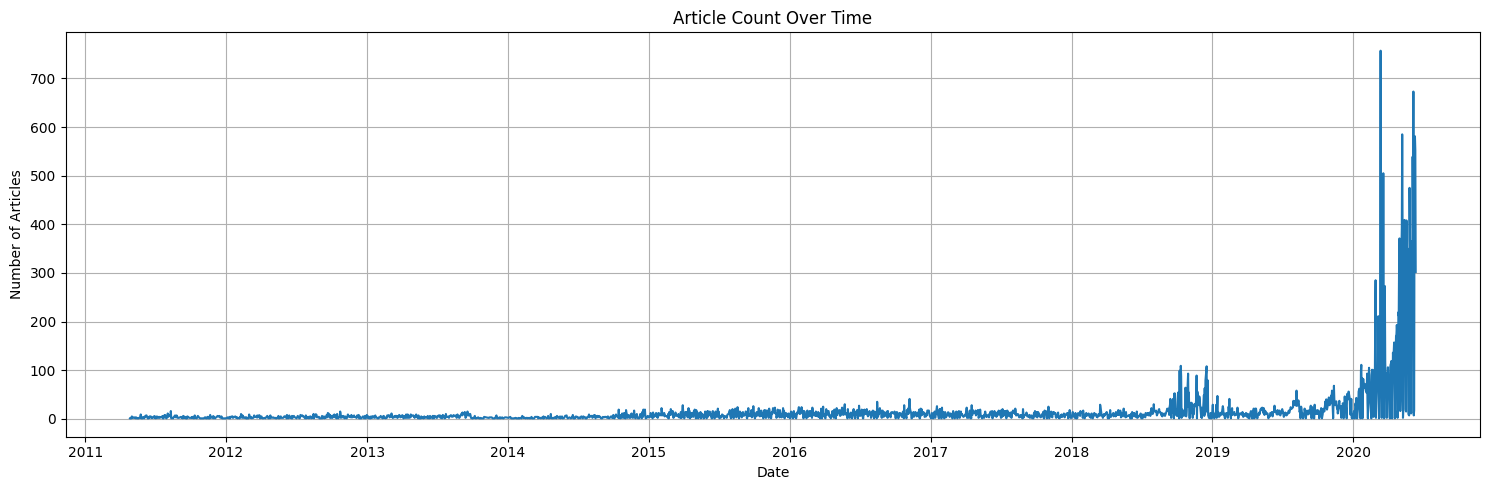

In [16]:
# --- Time Series Analysis ---
daily_counts = df['date'].dt.date.value_counts().sort_index()
plt.figure(figsize=(15, 5))
daily_counts.plot()
plt.title("Article Count Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.tight_layout()
plt.show()

The time series analysis highlights that financial news publications are event-driven and market-aligned, with:
 1. High alignment with trading hours and market calendars.
 2. Volatility in article volume linked to macroeconomic or company-specific triggers.
 3. This behavior provides insights for traders and algorithms to time their strategies around predictable surges in market information flow.

 Text Analysis: Topic Modeling


 Text Preprocessing

Headlines were converted to lowercase and cleaned to remove punctuation.

Common stop words (like "the", "is", "and") were removed.

The result is a normalized version of each headline.

TF-IDF Vectorization

Words appearing in at least 5 documents but less than 95% of them were included.

This helps capture discriminative keywords across the corpus while ignoring noise.

LDA Model

The number of topics was set to 5 (a common starting point).

Each topic outputs a list of the top 10 keywords, showing the themes in your dataset.

In [18]:
# Basic text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['clean_headline'] = df['headline'].apply(clean_text)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_headline'])

# LDA Topic Modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Display Topics
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, tfidf_vectorizer.get_feature_names_out())


Topic #1:
etfs, etf, update, shares, market, announces, reports, says, markets, stock

Topic #2:
eps, estimate, sales, shares, trading, companies, q1, yoy, higher, vs

Topic #3:
stocks, hit, 52week, lows, highs, thursday, biggest, moving, friday, session

Topic #4:
new, set, low, stocks, yesterday, 52week, 2018, october, september, dec

Topic #5:
price, target, maintains, raises, lowers, buy, neutral, downgrades, morgan, market


Publisher Domain Analysis


Top Email Domains (if applicable):
domain
benzinga.com    908
gmail.com         3
Name: count, dtype: int64


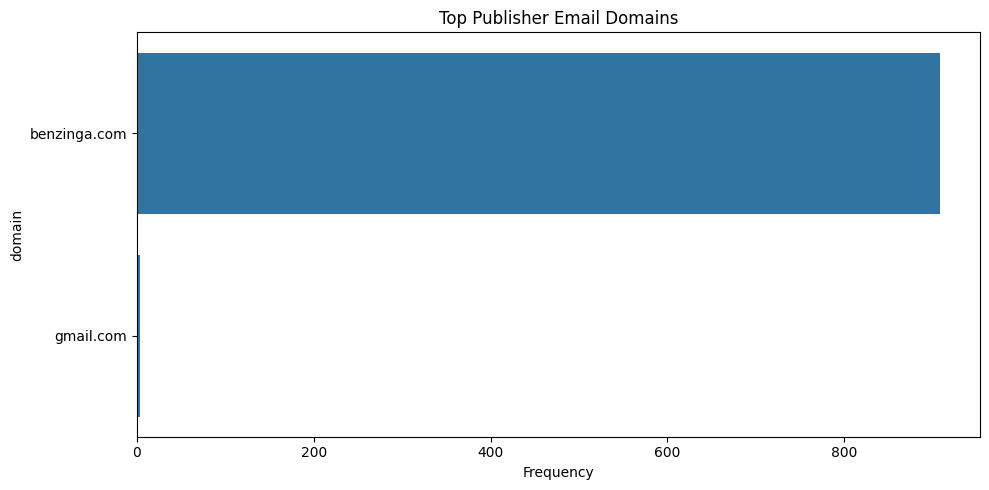

In [19]:
# If email-style publishers exist
df['domain'] = df['publisher'].str.extract(r'@([\w.-]+)')
domain_counts = df['domain'].value_counts().dropna()

if not domain_counts.empty:
    print("\nTop Email Domains (if applicable):")
    print(domain_counts.head())

    plt.figure(figsize=(10, 5))
    sns.barplot(x=domain_counts.head(10).values, y=domain_counts.head(10).index)
    plt.title("Top Publisher Email Domains")
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()
else:
    print("\nNo email-style publishers detected.")